In [150]:
import re
import nltk
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/burakgozutok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read Data

In [3]:
df = pd.read_csv('recipes.csv', delimiter=';')

# Filter nan columns for Ingredients and Directions
df = df[df['Ingredients'].notnull()]
df = df[df['Directions'].notnull()]
df.Directions = df.Directions.apply(lambda x: x.replace('**', ' '))

df.head(2)

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water. Stir in sugar, s...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001


In [124]:
ingredients_all = list(set([item for row in df.Ingredients for item in row.split(',') if len(item) > 0]))
#words_all = list(set([word for row in tqdm(df.Directions.to_list()) for word in nltk.word_tokenize(row)]))

words_all = [word for row in tqdm(df.Directions.to_list()) for word in nltk.word_tokenize(row)]
#words_all += list(nltk.ngrams(words_all, 2))

len(words_all), len(ingredients_all)

100%|██████████| 12345/12345 [00:08<00:00, 1423.84it/s]


(1245567, 942)

# Create Model Data

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(df, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_val, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

(9876, 1234, 1235)

In [135]:
def parse_df(df):
    ingredients_all = list(set([item for row in df.Ingredients for item in row.split(',') if (len(item) > 0 and " " not in item)]))
    words_all = list(set([word for row in tqdm(df.Directions.to_list()) for word in nltk.word_tokenize(row)]))

    words_0 = list(set(words_all) - set(ingredients_all))
    words_1 = ingredients_all

    x = words_0 + words_1
    y = [0 for i in range(len(words_0))] + [1 for i in range(len(words_0))]
    
    c = list(zip(x, y))
    random.shuffle(c)
    x, y = zip(*c)
    
    assert len(x) == len(y)
    return x,y

X_train_words, y_train_words = parse_df(X_train)
X_val_words, y_val_words = parse_df(X_val)
X_test_words, y_test_words = parse_df(X_test)

100%|██████████| 1235/1235 [00:00<00:00, 1322.22it/s]


# Vectorize Text

In [126]:
# Load FastText Model
#
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft_model = fasttext.load_model('cc.en.300.bin')

KeyboardInterrupt: 

In [136]:
# Vectorize Words
# 
X_train_vectors = [ft_model.get_sentence_vector(x) for x in X_train_words]
X_val_vectors = [ft_model.get_sentence_vector(x) for x in X_val_words]
X_test_vectors = [ft_model.get_sentence_vector(x) for x in X_test_words]

X_train_vectors = np.expand_dims(np.array(X_train_vectors), axis=2)
X_val_vectors = np.expand_dims(np.array(X_val_vectors), axis=2)
X_test_vectors = np.expand_dims(np.array(X_test_vectors), axis=2)

y_train_words = np.array(y_train_words)
y_val_words = np.array(y_val_words)
y_test_words = np.array(y_test_words)

X_train_vectors.shape, X_val_vectors.shape, X_test_vectors.shape

((7155, 300, 1), (3344, 300, 1), (3345, 300, 1))

# 1D CNN Model

In [137]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,InputLayer
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from tensorflow.keras.callbacks import EarlyStopping

### Create Model and visualize

In [138]:
model = Sequential()
model.add(InputLayer((300,1)))
model.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 293, 16)           144       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 146, 16)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2336)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2336)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                37392     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 37,553
Trainable params: 37,553
Non-trainable params: 0
_________________________________________________________________


### Calculate Class Weights for the imbalance

In [139]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train_words), class_weight.compute_class_weight('balanced', np.unique(y_train_words), 
                y_train))) 
class_weights

{0: 0.562610229276896, 1: 4.492957746478873}

### Train Model

In [140]:
history = model.fit(
        X_train_vectors, y_train_words, 
        validation_data=(X_val_vectors,y_val_words), 
        batch_size=32, 
        epochs=30,
        class_weight=class_weights,
        callbacks=[early_stop]
        )

Train on 7155 samples, validate on 3344 samples
Epoch 1/30
7155/7155 [==============================] - 1s 186us/step - loss: 0.6148 - acc: 0.9139 - val_loss: 0.4064 - val_acc: 0.9211
Epoch 2/30
7155/7155 [==============================] - 1s 94us/step - loss: 0.5498 - acc: 0.9509 - val_loss: 0.3621 - val_acc: 0.9211
Epoch 3/30
7155/7155 [==============================] - 1s 97us/step - loss: 0.5257 - acc: 0.9509 - val_loss: 0.3356 - val_acc: 0.9211
Epoch 4/30
7155/7155 [==============================] - 1s 83us/step - loss: 0.5004 - acc: 0.9509 - val_loss: 0.3126 - val_acc: 0.9211
Epoch 5/30
7155/7155 [==============================] - 1s 86us/step - loss: 0.4737 - acc: 0.9509 - val_loss: 0.2976 - val_acc: 0.9211
Epoch 6/30
7155/7155 [==============================] - 1s 90us/step - loss: 0.4355 - acc: 0.9539 - val_loss: 0.3065 - val_acc: 0.9360
Epoch 7/30
7155/7155 [==============================] - 1s 100us/step - loss: 0.4119 - acc: 0.9571 - val_loss: 0.2561 - val_acc: 0.9357
Epoch

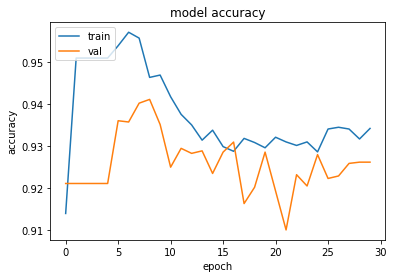

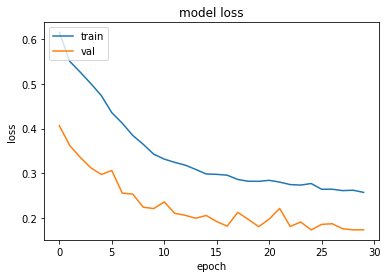

In [141]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate

In [142]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_vectors).squeeze()
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

print(classification_report(y_test_words,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      3071
           1       0.52      0.83      0.64       274

    accuracy                           0.92      3345
   macro avg       0.75      0.88      0.80      3345
weighted avg       0.95      0.92      0.93      3345



# Inference

In [164]:
def recipe_to_target_words(recipe):
    words = nltk.word_tokenize(recipe)
    word_vectors = np.array([ft_model.get_word_vector(word) for word in words])

    targets = []
    for i in range(len(word_vectors)):    
        n_gram_1 = word_vectors[i:i+1].mean(axis=0)
        n_gram_2 = word_vectors[i:i+2].mean(axis=0)    
        n_gram_3 = word_vectors[i:i+3].mean(axis=0)

        targets.append((words[i], n_gram_1))
        targets.append((' '.join(words[i:i+2]), n_gram_2))
        targets.append((' '.join(words[i:i+3]), n_gram_3))
    
    return targets

word,vec = recipe_to_target_words(X_test.iloc[0].Directions)[61]
word, vec.shape

('well blended', (300,))

In [171]:
def predict(text):
    targets = recipe_to_target_words(text)
    
    words = [t[0] for t in targets]
    vecs = np.array([np.expand_dims(t[1],axis=1) for t in targets])
    
    y_pred = model.predict(vecs) 
    y_pred = np.squeeze(y_pred > 0.5).astype(int)
    
    result = []
    for w,p in zip(words,y_pred):
        if p==1:
            result.append(w)
            
    return result
    
predict(X_test.iloc[0].Directions)

['molasses',
 'brown sugar',
 'sugar',
 'baking soda',
 'soda',
 'soda , ginger',
 'ginger',
 'ginger and cinnamon',
 'cinnamon',
 'cup',
 'coffee',
 'cup',
 'spice',
 'spice mixture',
 'cup',
 'coffee',
 'whipped cream',
 'cream',
 'cloves']

In [218]:
def post_filter(items):
    filtered = []
    filtered = [item for item in items]
    filtered = sorted(filtered, key=lambda x: len(x.split()), reverse=False)
    
    filtered2 = []
    for f in filtered:
        if ',' in f:
            filtered2 += f.split(',')
        if 'and' in f:
            filtered2 += f.split('and')
        if 'and' not in f and ',' not in f:
            filtered2.append(f)
        
    filtered = list(set(filtered2))        
    filtered = [f.strip() for f in filtered]
    
    
    
    ignore_items = []
    for item in filtered:
        for item2 in filtered:
            if len(item2) > len(item) and item in item2.split():
                ignore_items.append(item)
    
    # remove single word of "cup"
    ignore_items += ["cup"]
    filtered = list(set(filtered) - set(ignore_items))
        
    return filtered

post_filter(predict(X_test.iloc[0].Directions))

['cinnamon',
 'whipped cream',
 'cloves',
 'baking soda',
 'molasses',
 'coffee',
 'spice mixture',
 'brown sugar',
 'ginger']